In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

# Data exploration

Features:
- PassengerID
- Pclass - Ticket class - 1 = 1st, 2 = 2nd, 3 = 3rd
- Sex
- Age
- SibSp - # of siblings / spouses aboard the Titanic
- Parch - # of parents / children aboard the Titanic
- Ticket - Ticket number
- Fare
- Cabin - Cabin number
- Embarked - Port of Embarkation - C = Cherbourg, Q = Queenstown, S = Southampton

Target:
- Survived - 0 = No, 1 = Yes

In [3]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Handle missing values

In [4]:
def missing_values(df):
    for column in df.columns:
        if df[column].isna().any():
            print(column, df[column].isna().sum())

In [5]:
missing_values(df_train)

Age 177
Cabin 687
Embarked 2


In [6]:
missing_values(df_test)

Age 86
Fare 1
Cabin 327


Missing values:
- Age
    - mean values
    - drop the row
- Embarked
    - drop it
    - add additional category for nan
- Cabin
    - drop the column
- Fare
    - mean values

In [7]:
def fill_na(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Fare'].fillna(df['Fare'].mean(), inplace=True)
    df.dropna(subset=['Embarked'], inplace=True)
    

In [8]:
fill_na(df_train)
fill_na(df_test)

## Features correlation

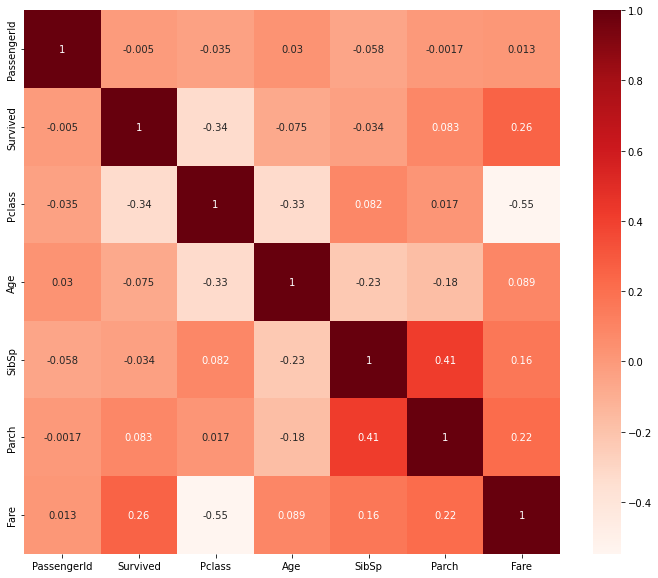

In [9]:
plt.figure(figsize=(12,10))
cor = df_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Based on the pearson correlation heatmap I decided to drop the PassangerID column.
Other observations:
- Fare is correlated with Parch
- Parch is correlated with SibSp

In [10]:
df_train['Sex'].describe()

count      889
unique       2
top       male
freq       577
Name: Sex, dtype: object

There is no significant inbalance

In [11]:
df_train['Age'].describe()

count    889.000000
mean      29.653446
std       12.968366
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

/Users/piokon/.pyenv/versions/3.8.1/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


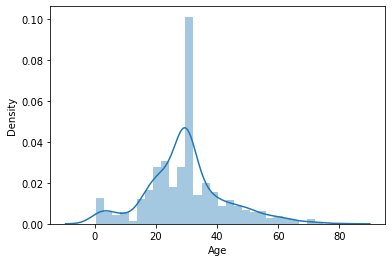

In [12]:
sns.distplot(df_train['Age']);

There is a significant spike of infants

In [13]:
df_train['Fare'].describe()

count    889.000000
mean      32.096681
std       49.697504
min        0.000000
25%        7.895800
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

/Users/piokon/.pyenv/versions/3.8.1/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


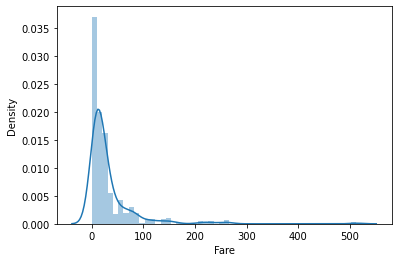

In [14]:
sns.distplot(df_train['Fare']);

In [15]:
df_train['Cabin'].describe()

count         202
unique        146
top       B96 B98
freq            4
Name: Cabin, dtype: object

Only 204/891 passangers has cabin - it should probably be dropped

In [16]:
df_train['Ticket'].describe()

count        889
unique       680
top       347082
freq           7
Name: Ticket, dtype: object

Everyone has a ticket number but I'm not sure if it'll help

In [17]:
def drop_features(df, columns):
    df = df.drop(columns=columns, inplace=True)
    
drop_features(df_train, ['Cabin'])
drop_features(df_test, ['Cabin'])

## Categorical features
- Pclass
- Sex
- Embarked

In [18]:
def encode_categorical_features(df, feature, prefix):
    categories = pd.get_dummies(df[feature], prefix=prefix)
    df[categories.columns] = categories.values
    df.drop(columns=[feature], inplace=True)
    

In [19]:
encode_categorical_features(df_train, 'Pclass', 'class')
encode_categorical_features(df_test, 'Pclass', 'class')

In [20]:
encode_categorical_features(df_train, 'Sex', 'sex')
encode_categorical_features(df_test, 'Sex', 'sex')

In [21]:
encode_categorical_features(df_train, 'Embarked', 'embarked')
encode_categorical_features(df_test, 'Embarked', 'embarked')

## Normalize features
- Age
- Fare

In [66]:
def normalize(df, columns):
    for column in columns:
        max_value = df[column].max()
        min_value = df[column].min()
        df[column] = (df[column] - min_value) / (max_value - min_value)

In [127]:
normalize(df_train, ['Age', 'Fare', 'SibSp', 'Parch'])
normalize(df_test, ['Age', 'Fare', 'SibSp', 'Parch'])

## Names and other strings
- Name
- Ticket

Let's try with n grams

In [99]:
names = np.concatenate((df_train['Name'].values, df_test['Name'].values))
tickets = np.concatenate((df_train['Ticket'].values, df_test['Ticket'].values))
corpus = np.concatenate((names, tickets))

In [117]:
char_vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 3))
char_vectorizer.fit_transform(corpus)

word_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 3))
word_vectorizer.fit_transform(corpus)

In [120]:
def add_ngrams(arr, arr_to_transform):
    n_grams_char = char_vectorizer.transform(arr_to_transform)
    n_grams_word = word_vectorizer.transform(arr_to_transform)
    return np.concatenate((arr, n_grams_char.toarray(), n_grams_word.toarray()), axis = 1)

# Classifier
- LR - max acc 79.4%
- XGboost - max 80.143%

In [178]:
columns = ['Age', 'SibSp', 'Parch', 'Fare', 'class_1', 'class_2', 'class_3', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q','embarked_S']

x_train = df_train.loc[:, columns].values
x_train = add_ngrams(x_train, df_train['Name'])
x_train = add_ngrams(x_train, df_train['Ticket'])
y_train = df_train['Survived'].values

x_test = df_test.loc[:, columns].values
x_test= add_ngrams(x_test, df_test['Name'])
x_test= add_ngrams(x_test, df_test['Ticket'])


import xgboost as xgb

# clf = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000, C=20)
# clf.fit(x_train, y_train)
dtrain = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test)

param = {'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'rmse'
evallist = [(dtrain, 'train')]

num_round = 40
bst = xgb.train(param, dtrain, num_round, evallist)
y_test_preds = bst.predict(d_test)

# y_test_preds = clf.predict(x_test)
y_test_preds = y_test_preds.reshape(len(y_test_preds), 1)

y_test_preds = np.array(list(map(lambda x: [1] if x[0] > 0.5 else [0], y_test_preds)))

ids = df_test['PassengerId'].values
ids = ids.reshape(len(ids), 1)

result = np.concatenate((ids, y_test_preds), axis=1)

np.savetxt("result.csv", result, delimiter=",", fmt='%i', header='PassengerId,Survived')


[0]	train-rmse:0.78584
[1]	train-rmse:0.43082
[2]	train-rmse:0.29239
[3]	train-rmse:0.27040
[4]	train-rmse:0.27040
[5]	train-rmse:0.25321
[6]	train-rmse:0.23952
[7]	train-rmse:0.22747
[8]	train-rmse:0.19556
[9]	train-rmse:0.18674
[10]	train-rmse:0.16770
[11]	train-rmse:0.16085
[12]	train-rmse:0.15369
[13]	train-rmse:0.14229
[14]	train-rmse:0.14229
[15]	train-rmse:0.14229
[16]	train-rmse:0.13416
[17]	train-rmse:0.12549
[18]	train-rmse:0.12093
[19]	train-rmse:0.10606
[20]	train-rmse:0.09486
[21]	train-rmse:0.08874
[22]	train-rmse:0.07500
[23]	train-rmse:0.06708
[24]	train-rmse:0.06708
[25]	train-rmse:0.05809
[26]	train-rmse:0.05809
[27]	train-rmse:0.00000
[28]	train-rmse:0.00000
[29]	train-rmse:0.00000
[30]	train-rmse:0.00000
[31]	train-rmse:0.00000
[32]	train-rmse:0.00000
[33]	train-rmse:0.00000
[34]	train-rmse:0.00000
[35]	train-rmse:0.00000
[36]	train-rmse:0.00000
[37]	train-rmse:0.00000
[38]	train-rmse:0.00000
[39]	train-rmse:0.00000


In [129]:
df_train

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,class_1,class_2,class_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1,0,"Braund, Mr. Owen Harris",0.271174,0.125,0.000000,A/5 21171,0.014151,0,0,1,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.472229,0.125,0.000000,PC 17599,0.139136,1,0,0,1,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",0.321438,0.000,0.000000,STON/O2. 3101282,0.015469,0,0,1,1,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.434531,0.125,0.000000,113803,0.103644,1,0,0,1,0,0,0,1
4,5,0,"Allen, Mr. William Henry",0.434531,0.000,0.000000,373450,0.015713,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,"Montvila, Rev. Juozas",0.334004,0.000,0.000000,211536,0.025374,0,1,0,0,1,0,0,1
887,888,1,"Graham, Miss. Margaret Edith",0.233476,0.000,0.000000,112053,0.058556,1,0,0,1,0,0,0,1
888,889,0,"Johnston, Miss. Catherine Helen ""Carrie""",0.367921,0.125,0.333333,W./C. 6607,0.045771,0,0,1,1,0,0,0,1
889,890,1,"Behr, Mr. Karl Howell",0.321438,0.000,0.000000,111369,0.058556,1,0,0,0,1,1,0,0


In [180]:
x_train.shape

(889, 28346)